# Support Vector Machines Exercises

In [2]:
# Install qsolvers and gurobi solver
#
!pip install qpsolvers
!pip install -i https://pypi.gurobi.com gurobipy

# Download data
#
!wget https://github.com/shegenbart/Jupyter-Exercises/raw/main/data/baseball.pickle -P ../data

Looking in indexes: https://pypi.gurobi.com
ERROR: Could not find a version that satisfies the requirement gurobipy (from versions: none)
ERROR: No matching distribution found for gurobipy
--2024-11-30 22:48:52--  https://github.com/shegenbart/Jupyter-Exercises/raw/main/data/baseball.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shegenbart/Jupyter-Exercises/main/data/baseball.pickle [following]
--2024-11-30 22:48:52--  https://raw.githubusercontent.com/shegenbart/Jupyter-Exercises/main/data/baseball.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177444 (173K) [application/octet-

In [3]:
#Imports, Helper Functions and Data Structures
#

import numpy as np
from qpsolvers import solve_qp
import numpy as np
import pickle

from dataclasses import dataclass
def load_dataset(filename):
    with open(filename, 'rb') as fd:
        dataset = pickle.load(fd)
    return dataset

# Baseball dataset
#
@dataclass
class Dataset:
    Description: str
    Attributes: list()
    Targets: list()
    X: np.array
    Y: np.array


# Helper functions needed for exercise
#
def plot_hyperplane(X,Y, n, b):
    """Plots the hyperplane defined by normalvector n and bias b.

    Parameters
    ----------
    X: np.array
        A two-dimensonal numpy array containing features.
    Y: np.array
        A one dimensional numpy array containing class labels. Class labels
        are assumed not to be one-hot encoded but categorical integer values.
    n: np.array
        A two-dimensional normalvector.
    b: float
        Bias of the hyperplane.

    Returns
    ----------
    Nothing
    """

    fig = plt.figure(figsize=(10,5))
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
    plt.scatter(X[Y == -1, 0], X[Y == -1, 1])

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = (np.dot(xy, n) - b).reshape(XX.shape)
    cs = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    plt.clabel(cs, inline=1)
    plt.grid(True)


def gen_data(npoints=10, linear_separable=True):

    assert npoints >= 4, 'Requires at least 4 points. '

    # Generate a random normal-vector
    #
    n = np.random.randn(2)
    n = n / np.linalg.norm(n)

    # Generate a random bias
    #
    b = np.random.randn(1)

    # Generate random points and label them such that they are linearly separable
    #
    X = np.random.randn(npoints,2) * 5

    tmp = np.dot(X, n) - b > 0
    Y = np.zeros(tmp.shape)
    Y[tmp == True] = 1
    Y[tmp == False] = -1

    if linear_separable == False:
        np.random.shuffle(Y)

    fig = plt.figure(figsize=(15,7))
    plt.scatter(X[Y == 1,0], X[Y == 1,1])
    plt.scatter(X[Y == -1,0], X[Y == -1,1])
    plt.grid(True)

    return X,Y

import numpy as np
import matplotlib.pyplot as plt

def plot_svm(X,Y, clf):

    fig = plt.figure(figsize=(15,7))
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
    plt.scatter(X[Y == -1, 0], X[Y == -1, 1])

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    cs = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    plt.clabel(cs, inline=1)
    plt.grid(True)

## Exercise: SVM Hard-Margin

Remember: We formulated the search for the best hyperplane as an optimization problem of the form

$$\begin{equation*}
\begin{aligned}
& \underset{n}{\text{minimize}}
& & \|n\| = \sum_i n_i^2 \\
& \text{subject to}
& &y_i (n \cdot x_i -b) \geq 1, \quad \forall i.
\end{aligned}
\end{equation*}$$


We have a quadratic objective function and linear constraints. Problems of this sort are known as quadratic programs (QP).

Quadratic programs are defined as
$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \frac{1}{2} x^T P x + q^Tx \\
& \text{subject to}
& & Gx \leq h \\
& & & A x = b \\
& & & lb \leq x \leq ub
\end{aligned}
\end{equation*}$$

We use a QP solver to find our solution given a set of linear equality constraints and a set of linear inequality constraints. In our example, there are only inequality constraints and an objective function, we therefore have to **define** $P$, $q$, $G$ and $h$.

In this example we assume our points are 2-dimensional. Therefore the normalvector of our plane is only 2-dimensional $n=(n_x, n_y)^T$.




### Exercise 1:
We start by defining our objective function in the form $\frac{1}{2} x^T P x + q^Tx$ where $x$ is a vector of our variables $(n_x, n_y, b)$, $P$ is a quadratic cost-matrix and $q$ is a cost-vector.

Find a 3x3-matrix $P$ and a 1x3-vector $q$ such that:

$(n_x, n_y, b)\; P\; (n_x, n_y, b)^T + q\; (n_x, n_y, b)^T= n_x^2 + n_y^2$

*This exercise is best solved using pen and paper. Write your solution down here for later reference.*

### Exercise 2:


We next have to convert our constraints from $\geq$ to $\leq$. We do this by multiplying the inequality with $-1$

$$y_i (n \cdot x_i -b) \geq 1 = -y_i (n \cdot x_i -b) \leq -1$$

For a given set of two points $x_1 = (x_{11}, x_{12}) = (3,2),\, x_2 = (x_{21},x_{22}) = (-3,4)$ with labels $y_1 = 1, y_2 = -1$
Find the matrix $G$ such that

$G\; (n_x, n_y, b)^T = \begin{pmatrix}
-y_1( n\cdot x_1 -b)\\
-y_2( n\cdot x_2 -b)
\end{pmatrix} = \begin{pmatrix}
-y_1( n_x x_{11}  + n_y x_{12} -b)\\
-y_2( n_x x_{21}  + n_y x_{22} -b)
\end{pmatrix} = \begin{pmatrix}
-3n_x  - 2n_y + b\\
-3n_x  + 4n_y  -b
\end{pmatrix}$


*This exercise is best solved using pen and paper. Write your solution down here for later reference.*

### Exercise 3:

Manually define $P$, $q$, $G$ and $h$ using appropriate numpy-arrays to solve the optimization problem with ```solve_qp(P,q,G,h)```. Then plot your results using the ```plot_hyperplane()``` function.

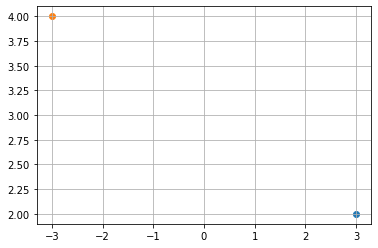

In [ ]:
# Generates and plots the training data
#
X = np.array([[3, 2], [-3, 4]])
Y = np.array([1, -1])


import matplotlib.pyplot as plt
plt.scatter(X[Y == 1,0], X[Y == 1,1])
plt.scatter(X[Y == -1,0], X[Y == -1,1])
plt.grid(True)


### Exercise 4:

We saw that $P$ and $q$ do not depend on our training-data. But $G$ and $h$ does depend on our training-data.
* Implement a function that creates a matrix $G$ and vector $h$ based on a given set of training features $X$ and labels $Y$.
* Use the ```gen_data()```function to generate data and use your implementation to find a hyperplane via ```solve_qp(P,q,G,h)``` and plot it.
* Generate some non-linearly separable data using ```gen_data(linear_separable=False)```and try to find a hyperplane using the ```solve_qp(P,q,G,h)``` function, what happens and why?

## Exercise: SVM in scikit-learn

Let us now use the implementation of SVM from scikit-learn.

## Exercise 1:

* Generate some data using ```X,Y = gen_data()```.
* Train a linear support vector machine using scikit-learn.
* Plot your decision boundary using the ```plot_svm(X,Y,clf)``` function.
* Have a look at the decision boundary (you can find the values of the normal vectors and bias term using clf.coef_[0] and clf.intercept_). What does it tell you?
* If you did the Hard-Margin SVM Exercises:
    * Compare the decision boundary found by scikit-learn to the decision boundary you would find using your **Hard-Margin SVM** from the previous exercise using the same training data.
    * Compare the values of the normal vectors and bias term (clf.coef_[0] and clf.intercept_) to your **Hard-Margin** solution.

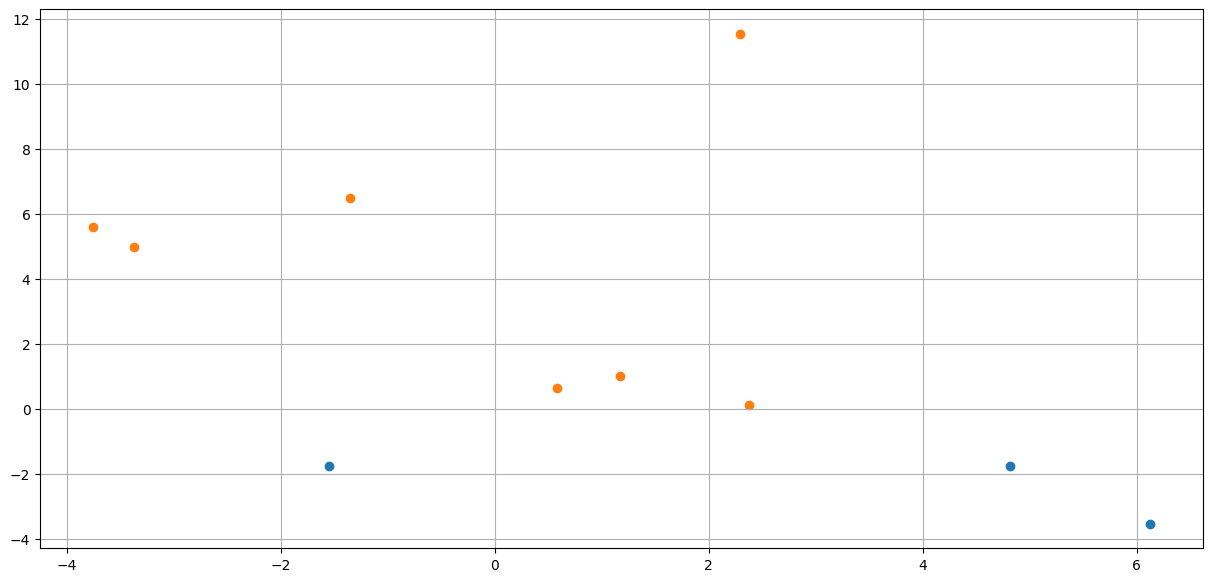

In [4]:
from sklearn.svm import SVC
X,Y = gen_data()

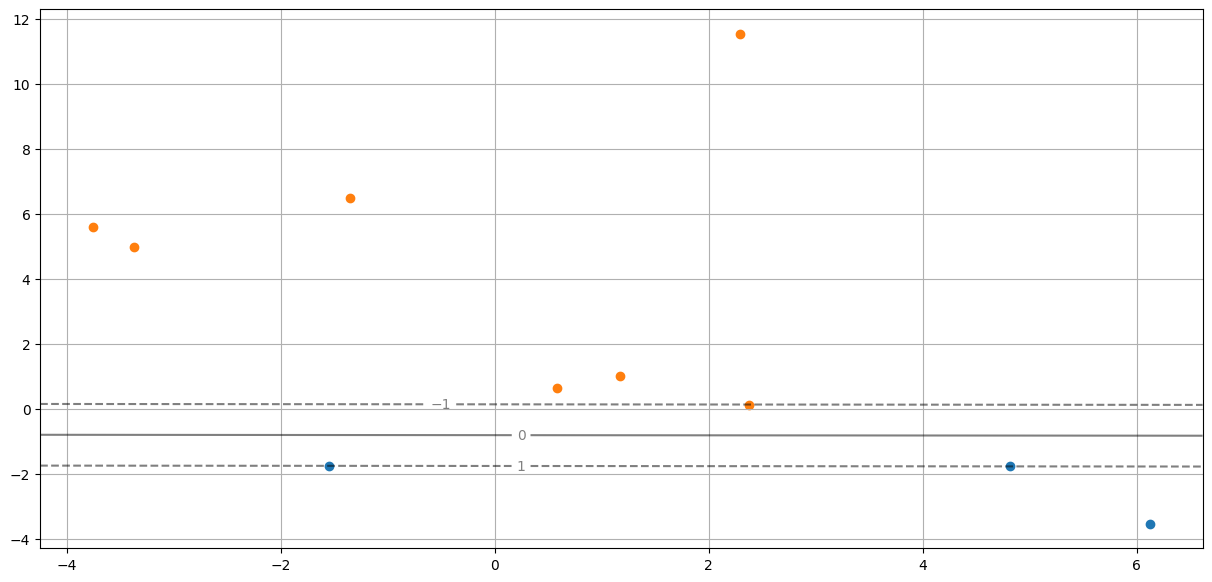

In [5]:
clf = SVC(kernel='linear')
clf.fit(X,Y)
plot_svm(X,Y,clf)

In [6]:
print("Normal vector: ", clf.coef_[0])
print("Bias: ", clf.intercept_)

Normal vector:  [-0.00276639 -1.05472925]
Bias:  [-0.86002686]


The normal vector is the normal vector of the decision boundary. This means it is orthogonal (90 degree) to the decision boundary. Every point x on the decision boundary follows the formula = <x, normalvector> + bias = 0
The bias then basically is part of this formula. It basically allows the shift of the decision boundary away from the origin. Without it, every decision boundary would always pass through the origin.

## Exercise 2:

* Generate some data using ```X,Y = gen_data(linear_separable=False)```.
* Train a linear support vector machine using scikit-learn.
* Plot your decision boundary using the ```plot_svm(X,Y,clf)``` function.
* Train another suppor vector machine using the kernel trick in scikit-learn.
* Plot your decision boundary of the non-linear svm using the ```plot_svm(X,Y,clf)``` function. How does the decision boundary change? What could possibly happen?

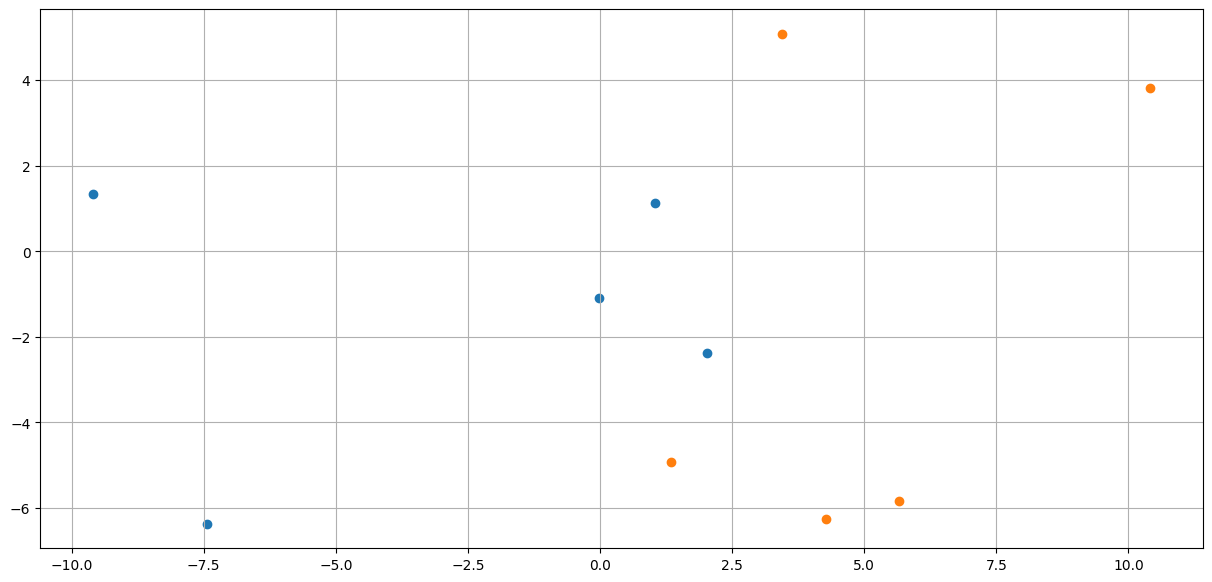

In [14]:
X,Y = gen_data(linear_separable=False)

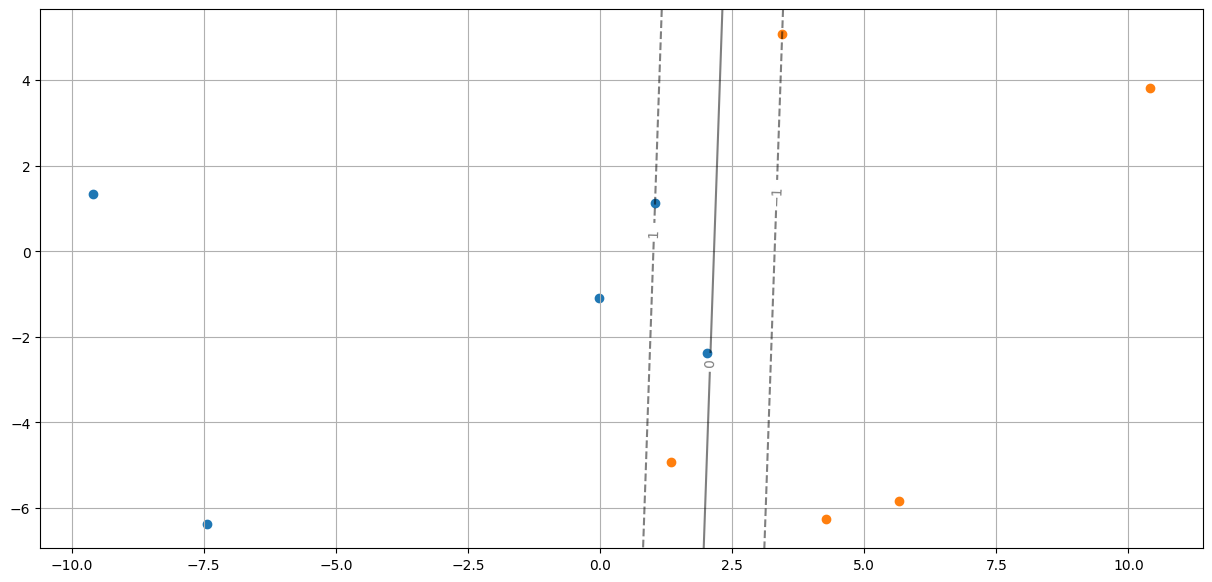

In [15]:
clf = SVC(kernel='linear')
clf.fit(X,Y)
plot_svm(X,Y,clf)

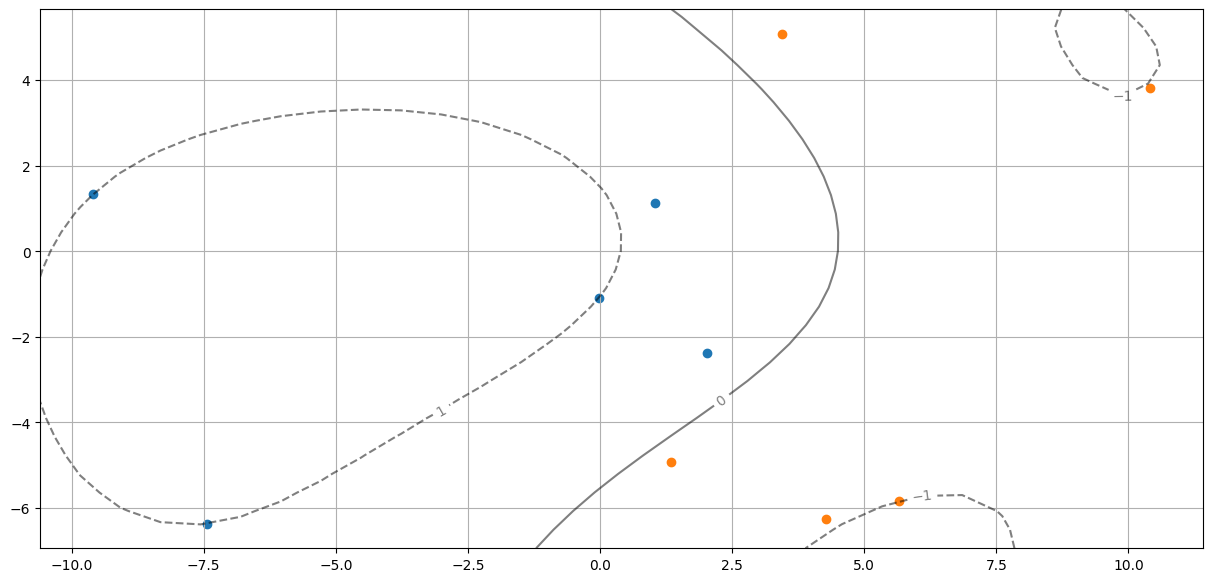

In [16]:
clf = SVC(kernel='rbf')
clf.fit(X,Y)
plot_svm(X,Y,clf)

You can see, that the Linear SVM is not able to completely seperate the two group from each other. It just picks the best decision boundary with allowing some kind of error to it.

The Support Vector Machine with the RBF-kernel-trick is able to fully seperate the data correctly though.  It is now not a linear line but more of defined regions. You can kind of see hof the data is being transformed into a higher dimension, where you can linear seperate it.

The kernel-trick has a high possibility of overfitting to the data, because it just searches for a transformation that fits for the linear seperation of the current train-data the best. It could be, that using the kernel-trick could be very bad for general predictions.

## Exercise 3:

* Load the baseball dataset using ```load_dataset(../data/baseball.pickle)```.
* Have a look at the dataset, there are multiple fields such as Attributes, Targets, Description, ...
* Train a support vector machine that predicts wether a player will end up in the hall-of-fame or not (you can use the ```accuracy_score()``` method from sklearn to easily do this.
* Compare a linear and a non-linear SVM, what is better?

**Notice:**

Do not train and test on the same set of data, this will result in too high accuracy. Instead use cross validation such as:

```python
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(baseball.X, baseball.Y)
```

Then train on ```X_train, Y_train``` and predict using ```X_test and Y_test```.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
baseball = load_dataset("../data/baseball.pickle")

In [18]:
baseball.Description

'Statistics of professional Baseball players.'

In [19]:
baseball.Attributes

['Number_seasons',
 'Games_played',
 'At_bats',
 'Runs',
 'Hits',
 'Doubles',
 'Triples',
 'Home_runs',
 'RBIs',
 'Walks',
 'Strikeouts',
 'Batting_average',
 'On_base_pct',
 'Slugging_pct',
 'Fielding_ave',
 'Position']

In [20]:
baseball.Targets

['Hall of Fame']

In [24]:
def compare_linear_kernel_SVM(X, Y, random_state):
  X_train, X_test, Y_train, Y_test = train_test_split(baseball.X, baseball.Y, test_size=0.33, random_state=random_state)

  linearSVM = SVC(kernel="linear")
  kernelSVM = SVC(kernel="rbf")

  linearSVM = linearSVM.fit(X_train,Y_train)
  kernelSVM = kernelSVM.fit(X_train, Y_train)

  predLinear = linearSVM.predict(X_test)
  predKernel = kernelSVM.predict(X_test)

  return (accuracy_score(Y_test, predLinear), accuracy_score(Y_test, predKernel))

In [27]:
results = []

for i in range(0, 10):
  results.append(compare_linear_kernel_SVM(baseball.X, baseball.Y, i))

In [28]:
diff = 0

for result in results:
  print("Linear: ", result[0], "Kernel: ", result[1])
  diff = diff + result[0] - result[1]

print("\nThe linear SVM is average percentage better: ", diff / len(results))

Linear:  0.945823927765237 Kernel:  0.9322799097065463
Linear:  0.9300225733634312 Kernel:  0.9142212189616253
Linear:  0.8961625282167043 Kernel:  0.9209932279909706
Linear:  0.9232505643340858 Kernel:  0.9119638826185101
Linear:  0.9571106094808126 Kernel:  0.9390519187358917
Linear:  0.945823927765237 Kernel:  0.9413092550790068
Linear:  0.9187358916478555 Kernel:  0.9232505643340858
Linear:  0.9187358916478555 Kernel:  0.9142212189616253
Linear:  0.9322799097065463 Kernel:  0.9142212189616253
Linear:  0.9322799097065463 Kernel:  0.9255079006772009

The linear SVM is average percentage better:  0.006320541760722343


So over 10 random test-splits the linear SVM performed 0.6% better than the SVM with kernel-trick. So it seems like their is no need to perform a kernel-trick on this kind of data. With an accuracy of about 93% the linear SVM achieved a pretty good job of predicting wether a baseball-player ends up in the hall of fame or not.